In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.chdir("/kaggle/input/eegdata")

/kaggle/input/eegdata/y_test.npy
/kaggle/input/eegdata/main.py
/kaggle/input/eegdata/y_train_valid.npy
/kaggle/input/eegdata/person_train_valid.npy
/kaggle/input/eegdata/EEG_pl.py
/kaggle/input/eegdata/X_test.npy
/kaggle/input/eegdata/dataset.py
/kaggle/input/eegdata/EEG_loading.ipynb
/kaggle/input/eegdata/person_test.npy
/kaggle/input/eegdata/X_train_valid.npy
/kaggle/input/eegdata/classifier.py


### Shape of data

In [61]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import regularizers

In [6]:
## Loading the numpy arrays corresponding to the EEG dataset



X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [7]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [8]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 1000, 1)
Shape of validation set after adding width info: (500, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (1615, 1000, 1, 22)
Shape of validation set after dimension reshaping: (500, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


In [68]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=16, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22),kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.01)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))) # Output FC layer with softmax activation

# Printing the model summary
basic_cnn_model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 1000, 1, 16)       3536      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 334, 1, 16)        0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 334, 1, 16)        64        
_________________________________________________________________
dropout_49 (Dropout)         (None, 334, 1, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 334, 1, 32)        5152      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 112, 1, 32)        0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 112, 1, 32)      

In [69]:
# Model parameters
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-3
epochs = 200
cnn_optimizer = Adam(lr=learning_rate)

In [70]:
# Compiling the model
from keras.callbacks import EarlyStopping

basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', patience=25)]

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=32,
             epochs=epochs,
             validation_data=(x_valid, y_valid),
             #callbacks=callbacks,
             verbose=True)

Epoch 1/200
51/51 [==============================] - 2s 13ms/step - loss: 3.9823 - accuracy: 0.2848 - val_loss: 3.3361 - val_accuracy: 0.3480
Epoch 2/200
51/51 [==============================] - 0s 7ms/step - loss: 3.7271 - accuracy: 0.3294 - val_loss: 3.2523 - val_accuracy: 0.3460
Epoch 3/200
51/51 [==============================] - 0s 7ms/step - loss: 3.5769 - accuracy: 0.3344 - val_loss: 3.2998 - val_accuracy: 0.3200
Epoch 4/200
51/51 [==============================] - 0s 7ms/step - loss: 3.3640 - accuracy: 0.3628 - val_loss: 3.1537 - val_accuracy: 0.3340
Epoch 5/200
51/51 [==============================] - 0s 7ms/step - loss: 3.2696 - accuracy: 0.3734 - val_loss: 3.0624 - val_accuracy: 0.3320
Epoch 6/200
51/51 [==============================] - 0s 7ms/step - loss: 3.2154 - accuracy: 0.3690 - val_loss: 2.9450 - val_accuracy: 0.3880
Epoch 7/200
51/51 [==============================] - 0s 7ms/step - loss: 3.0379 - accuracy: 0.3882 - val_loss: 3.0332 - val_accuracy: 0.3040
Epoch 8/200


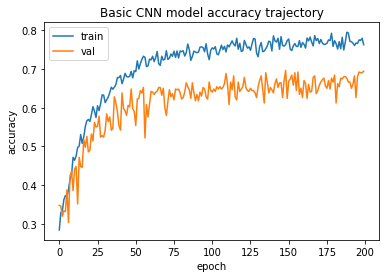

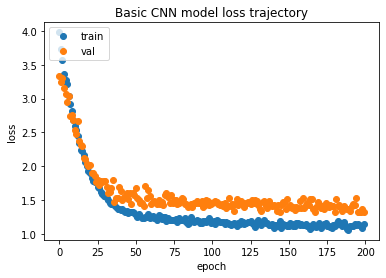

In [71]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7065462470054626
